In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
df = pd.read_csv('onion_price_2012_to_2024_cleaned.csv')
df['Min Price (Rs./Quintal)'] = df['Min Price (Rs./Quintal)'].fillna(df['Min Price (Rs./Quintal)'].mean())
df['Max Price (Rs./Quintal)'] = df['Max Price (Rs./Quintal)'].fillna(df['Max Price (Rs./Quintal)'].mean())
df['Modal Price (Rs./Quintal)'] = df['Modal Price (Rs./Quintal)'].fillna(df['Modal Price (Rs./Quintal)'].mean())
df = df.drop(columns=['Variety', 'Grade', 'Sl no.'])
# Convert 'Price Date' to datetime
df['Price Date'] = pd.to_datetime(df['Price Date'], errors='coerce')
df.dropna(subset=['Price Date'], inplace=True)

# Extract Year, Month, Day
df['Year'] = df['Price Date'].dt.year
df['Month'] = df['Price Date'].dt.month
df['Day'] = df['Price Date'].dt.day

# Calculate average price
df['Average Price'] = (df['Min Price (Rs./Quintal)'] + df['Max Price (Rs./Quintal)'] + df['Modal Price (Rs./Quintal)']) / 3

# Categorize the average price into 'Low', 'Mid', 'High'
df['Price Category'] = pd.cut(df['Average Price'], bins=[0, 1000, 2000, float('inf')], labels=['Low', 'Mid', 'High'])
df.head()

,District Name,Market Name,Commodity,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date,Year,Month,Day,Average Price,Price Category
0,Fazilka,Abohar,Onion,450.0,650.0,500.0,2012-01-02,2012,1,2,533.333333,Low
1,Fazilka,Abohar,Onion,450.0,650.0,500.0,2012-05-07,2012,5,7,533.333333,Low
2,Fazilka,Abohar,Onion,450.0,650.0,500.0,2012-05-11,2012,5,11,533.333333,Low
3,Fazilka,Abohar,Onion,500.0,800.0,700.0,2012-08-07,2012,8,7,666.666667,Low
4,Fazilka,Abohar,Onion,500.0,800.0,700.0,2012-07-26,2012,7,26,666.666667,Low


In [3]:
# Features and Target
X = df[['Year', 'Month', 'Day']]
y = df['Price Category']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# Extra: LSTM Model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape data for LSTM
X_lstm = df[['Average Price']].values
scaler_lstm = StandardScaler()
X_lstm = scaler_lstm.fit_transform(X_lstm)

# Create dataset for LSTM
def create_dataset(X, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step - 1):
        Xs.append(X[i:(i + time_step), 0])
        ys.append(X[i + time_step, 0])
    return np.array(Xs), np.array(ys)

time_step = 10
X_lstm, y_lstm = create_dataset(X_lstm, time_step)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

# Split data
train_size = int(len(X_lstm) * 0.7)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]


In [5]:
# Train LSTM Model
lstm_model = create_lstm_model((X_train_lstm.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=1, verbose=1)
lstm_predictions = lstm_model.predict(X_test_lstm)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59894/59894 ━━━━━━━━━━━━━━━━━━━━ 423s 7ms/step - loss: 0.4464
Epoch 2/10
59894/59894 ━━━━━━━━━━━━━━━━━━━━ 423s 7ms/step - loss: 0.4310
Epoch 3/10
59894/59894 ━━━━━━━━━━━━━━━━━━━━ 447s 7ms/step - loss: 0.4206
Epoch 4/10
59894/59894 ━━━━━━━━━━━━━━━━━━━━ 444s 7ms/step - loss: 0.4217
Epoch 5/10
59894/59894 ━━━━━━━━━━━━━━━━━━━━ 402s 7ms/step - loss: 0.4182
Epoch 6/10
59894/59894 ━━━━━━━━━━━━━━━━━━━━ 403s 7ms/step - loss: 0.4076
Epoch 7/10
59894/59894 ━━━━━━━━━━━━━━━━━━━━ 444s 7ms/step - loss: 0.4107
Epoch 8/10
59894/59894 ━━━━━━━━━━━━━━━━━━━━ 409s 7ms/step - loss: 0.4041
Epoch 9/10
59894/59894 ━━━━━━━━━━━━━━━━━━━━ 440s 7ms/step - loss: 0.4070
Epoch 10/10
59894/59894 ━━━━━━━━━━━━━━━━━━━━ 411s 7ms/step - loss: 0.4004
803/803 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


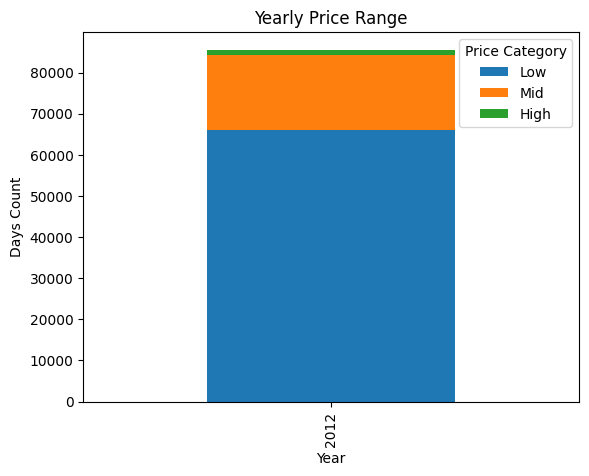

In [13]:
# 1. Yearly price range
df['Year'] = pd.to_datetime(df[['Year', 'Month', 'Day']]).dt.year
# Explicitly setting observed=False to match the current behavior
price_categories = df.groupby(['Year', 'Price Category'], observed=False).size().unstack(fill_value=0)
price_categories.plot(kind='bar', stacked=True)
plt.title('Yearly Price Range')
plt.xlabel('Year')
plt.ylabel('Days Count')
plt.show()


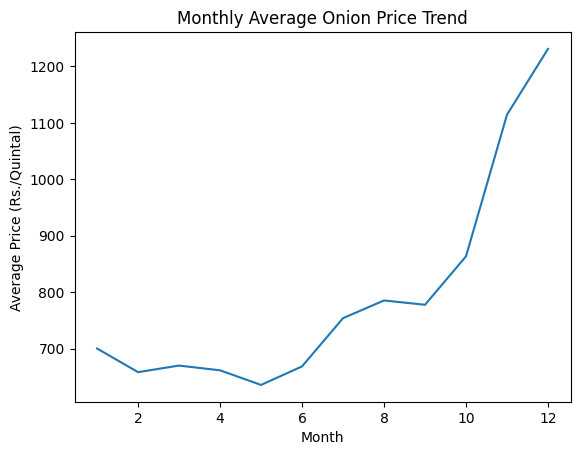

In [11]:
# 2. Monthly price trend
monthly_avg = df.groupby('Month')['Average Price'].mean()
plt.plot(monthly_avg)
plt.title('Monthly Average Onion Price Trend')
plt.xlabel('Month')
plt.ylabel('Average Price (Rs./Quintal)')
plt.show()

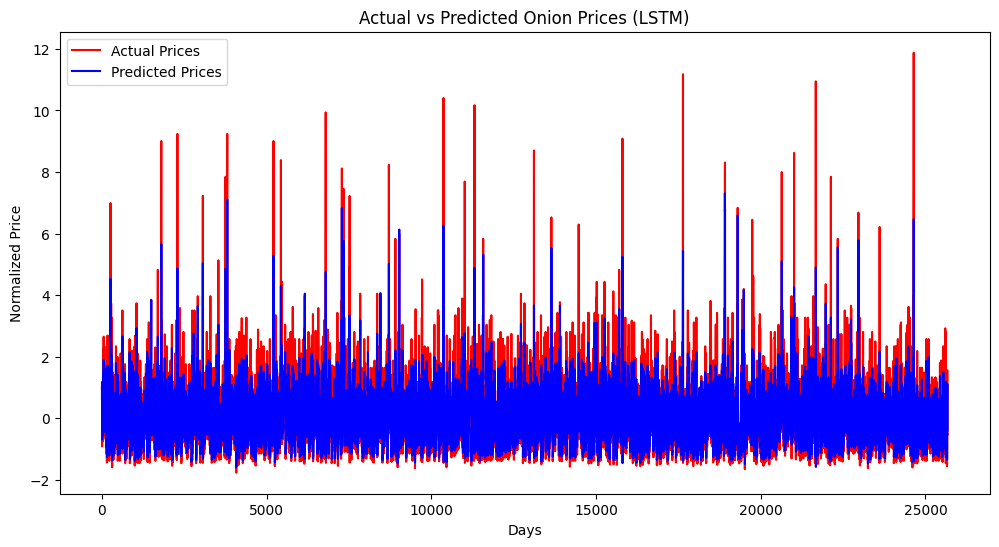

In [10]:
# 3. Actual vs Predicted Prices (LSTM)
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm, label='Actual Prices', color='red')
plt.plot(lstm_predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Onion Prices (LSTM)')
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()